# Flow Matching Optimal Transport

In this notebook, we explore a neural optimal transport framework based on *flow matching*. The approach leverages contrastive learning to build a shared latent embedding space between two modalities and then uses entropic optimal transport to perform soft matching. By doing so, we can learn mappings between distributions even in challenging settings where the observations are noisy or heterogeneous.

We demonstrate:
- **Contrastive Learning for Modality Alignment:** Mapping measurements to a unified latent space so that matching samples are close.
- **Entropic Optimal Transport:** Computing an approximate maximum weight bipartite matching with regularization.
- **Efficient Training with Batch Conditioning:** Reducing the search space and mitigating distribution shifts through a transductive setting.

Our goal is to illustrate the training and evaluation steps of the Flow Matching OT model while visualizing its performance on synthetic datasets.

## Setup and Helper Functions

We begin by importing required libraries and defining helper functions. These include data loaders for synthetic distributions as well as visualization routines that plot the source and transported distributions. In addition, we define functions to generate synthetic batches and compute pairwise distances used for matching.

In [1]:
import jax
import jax.numpy as jnp
import numpy as np
import optax
import matplotlib.pyplot as plt
import time
from ott import datasets
from ott.neural.networks.velocity_field import VelocityField
from ott.neural.methods.flows.otfm import OTFlowMatching
from ott.neural.methods.flows.dynamics import ConstantNoiseFlow
from ott.solvers import utils as solver_utils

## Data Generation and Visualization

We use synthetic data to simulate source and target distributions. For example, the source samples and target samples can be drawn uniformly from a 2-D space. In each batch, the source and target are paired along with their corresponding conditions.

We then visualize the initial distributions to understand the problem setting before training the model.

In [2]:
def loader_from_dataset(ds, n_batches):
    for _ in range(n_batches):
        src = next(ds.source_iter)
        tgt = next(ds.target_iter)
        tgt_mod = tgt  # Modify target distribution if needed
        yield {"src_lin": src, "tgt_lin": tgt_mod, "src_condition": src}

def plot_initial(source, target, title="Initial Distributions"):
    plt.figure(figsize=(6,6))
    plt.scatter(source[:, 0], source[:, 1], c="blue", label="Source", alpha=0.6)
    plt.scatter(target[:, 0], target[:, 1], c="green", label="Target", alpha=0.6)
    plt.xlabel("x")
    plt.ylabel("y")
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()

def plot_transport(source, transported, title="Flow Matching Transport"):
    plt.figure(figsize=(6,6))
    plt.scatter(source[:, 0], source[:, 1], c="blue", label="Source", alpha=0.6)
    plt.scatter(transported[:, 0], transported[:, 1], c="red", label="Transported", alpha=0.6)
    for i in range(source.shape[0]):
        plt.arrow(
            source[i, 0],
            source[i, 1],
            transported[i, 0] - source[i, 0],
            transported[i, 1] - source[i, 1],
            head_width=0.02, head_length=0.03, fc='gray', ec='gray', alpha=0.5
        )
    plt.xlabel("x")
    plt.ylabel("y")
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()

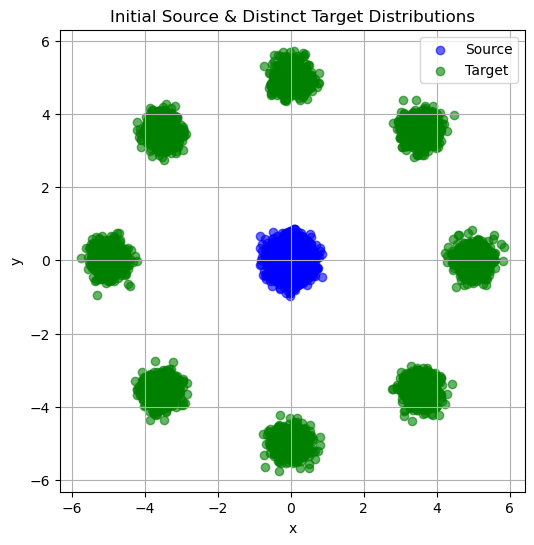

In [30]:
num_samples_visualize = 5000
(train_dataloaders, valid_dataloaders, input_dim) = datasets.create_gaussian_mixture_samplers(
    name_source="simple",
    name_target="circle",
    train_batch_size=num_samples_visualize,
    valid_batch_size=num_samples_visualize,
)

valid_source = next(valid_dataloaders.source_iter)
valid_target = next(valid_dataloaders.target_iter)
valid_target_mod = valid_target
plot_initial(valid_source, valid_target_mod, title="Initial Source & Distinct Target Distributions")

## Model Setup

The Flow Matching OT model consists of:
- A **Velocity Field (vf):** Implemented as a neural network that learns the transport dynamics.
- A **Flow Component:** For instance, a constant noise flow (with a specified sigma) to simulate the propagation of samples in the latent domain.
- An **Optimal Transport Matching Function:** Based on entropic regularization, it computes soft assignments between source and target. The matching function is derived from the negative Euclidean distance, ensuring that closer pairs receive higher matching scores.

An optimizer (e.g., ADAM) is used to initialize the training process, and a random seed is set for reproducibility.

In [21]:
vf = VelocityField(hidden_dims=[128, 128, 128], output_dims=[2])
flow = ConstantNoiseFlow(sigma=0.1)
optimizer = optax.adabelief(1e-3)
rng_init = jax.random.PRNGKey(0)

ot_flow_matching = OTFlowMatching(
    vf, flow, time_sampler=solver_utils.uniform_sampler,
    rng=rng_init, optimizer=optimizer
)

## Training the Model

The training loop consists of multiple epochs. For each epoch:

1. **Data Loading:** The model iterates over batches provided by the synthetic data loader.
2. **Contrastive Representation Learning:** The model encodes modalities into a shared latent space where corresponding source and target samples are aligned.
3. **Optimal Transport Matching:** The embedded representations are soft-matched using the entropic optimal transport module.
4. **Loss Computation and Backpropagation:** A mean-squared error loss is computed between the predicted dynamics and target values, and the model parameters are updated via backpropagation.

Training logs are maintained to record the loss at each iteration, and average epoch losses are reported to monitor convergence.

In [31]:
n_epochs = 1
n_train_batches = 5000
n_iters_per_epoch = n_train_batches

all_losses = []

for epoch in range(n_epochs):
    print(f"Epoch {epoch + 1}/{n_epochs}")
    rng = jax.random.PRNGKey(int(time.time()))
    train_loader = loader_from_dataset(train_dataloaders, n_train_batches)
    logs = ot_flow_matching(train_loader, n_iters=n_iters_per_epoch, rng=rng)
    epoch_loss = logs["loss"]
    all_losses.extend(epoch_loss)
    print(f"Average loss for epoch {epoch + 1}: {np.mean(epoch_loss):.4f}")

print("Total training done. Final loss:", all_losses[-1])

Epoch 1/1
Average loss for epoch 1: 1.3215
Total training done. Final loss: 1.3740451335906982


## Evaluation and Visualization

After training, we evaluate the learned transport plan by applying the model to a test dataset. The `transport` function integrates the learned flow using a neural ODE solver.

The results are visualized by plotting:
- **Source Distribution:** Displayed in blue.
- **Transported Distribution:** Displayed in red.
- **Flow Arrows:** Illustrating the movement from original to transported points.

These visual comparisons allow us to assess how well the model has learned to match the source distribution to the target.

Original test data (first 5 rows):
[[ 0.12216712  0.03956028]
 [-0.04882848  0.5526268 ]
 [-0.28353128  0.02702082]
 [ 0.15719321 -0.50066674]
 [ 0.20921074 -0.03818622]]
Transported test data (first 5 rows):
[[ 4.3755407   0.2086572 ]
 [-0.14096642  5.507554  ]
 [-5.075793    0.03361943]
 [ 0.32375577 -5.422693  ]
 [ 4.7649646  -0.1574797 ]]


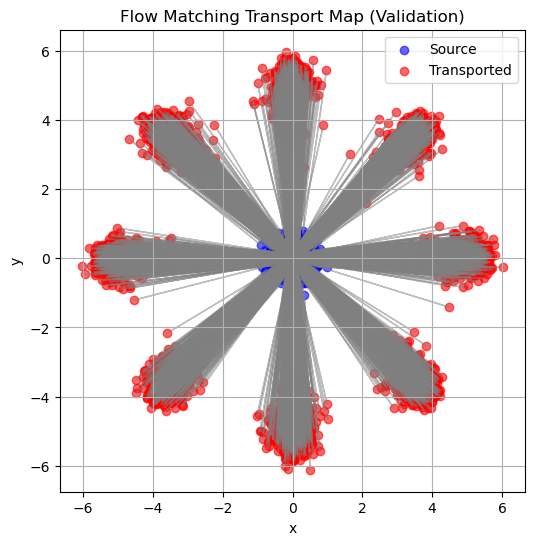

In [32]:
valid_source = next(valid_dataloaders.source_iter)
valid_target = next(valid_dataloaders.target_iter)
valid_target_mod = valid_target

test_data = jnp.asarray(valid_source)
transported = ot_flow_matching.transport(test_data, t0=0.0, t1=1.0)

print("Original test data (first 5 rows):")
print(test_data[:5])
print("Transported test data (first 5 rows):")
print(transported[:5])

source_np = np.array(test_data)
transported_np = np.array(transported)
plot_transport(source_np, transported_np, title="Flow Matching Transport Map (Validation)")

## Conclusion and Future Work

In this notebook, we demonstrated a neural optimal transport approach using flow matching. Key insights include:
- The use of contrastive learning to unify representations across modalities.
- The application of entropic optimal transport for soft matching between samples.
- The benefits of employing batch conditioning and transductive learning strategies to mitigate distribution shifts.

Future work may involve exploring more complex modalities or refining the network architecture to further enhance performance on real-world datasets.

## All at once

Finally, wrap everything into a `main()` function if you want to execute it all at once.


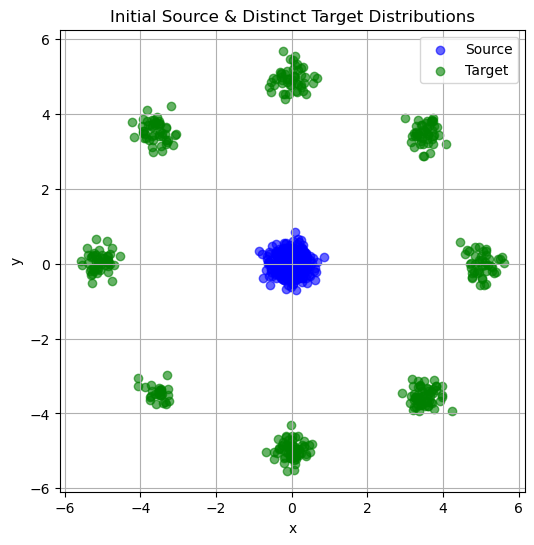

Epoch 1/10
Average loss for epoch 1: 2.0076
Epoch 2/10
Average loss for epoch 2: 1.4153
Epoch 3/10
Average loss for epoch 3: 1.3695
Epoch 4/10
Average loss for epoch 4: 1.3587
Epoch 5/10
Average loss for epoch 5: 1.3721
Epoch 6/10
Average loss for epoch 6: 1.3702
Epoch 7/10
Average loss for epoch 7: 1.3592
Epoch 8/10
Average loss for epoch 8: 1.3406
Epoch 9/10
Average loss for epoch 9: 1.3409
Epoch 10/10
Average loss for epoch 10: 1.3284
Total training done. Final loss: 1.3659948110580444
Original test data (first 5 rows):
[[ 0.12216712  0.03956028]
 [-0.04882848  0.5526268 ]
 [-0.28353128  0.02702082]
 [ 0.15719321 -0.50066674]
 [ 0.20921074 -0.03818622]]
Transported test data (first 5 rows):
[[ 4.411042    0.3122523 ]
 [-0.11206948  5.8501406 ]
 [-5.078423    0.04749829]
 [ 0.5654495  -5.2781    ]
 [ 4.6964602  -0.3067833 ]]


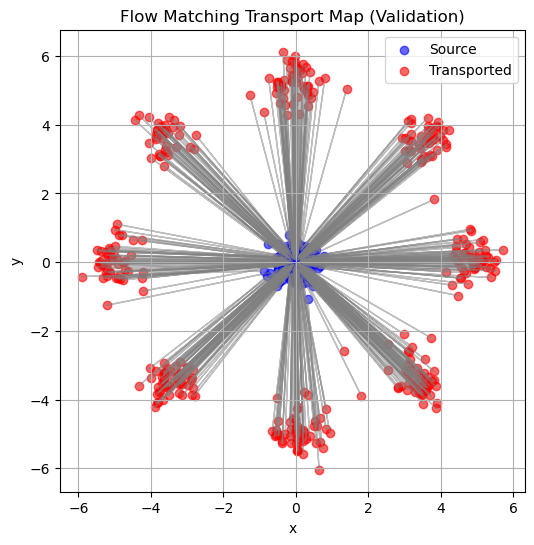

In [8]:
def main():
    # Get OTT's prepackaged Gaussian mixture sampler.
    num_samples_visualize = 400
    (train_dataloaders, valid_dataloaders, input_dim) = datasets.create_gaussian_mixture_samplers(
        name_source="simple",
        name_target="circle",
        train_batch_size=num_samples_visualize,
        valid_batch_size=num_samples_visualize,
    )
    
    valid_source = next(valid_dataloaders.source_iter)
    valid_target = next(valid_dataloaders.target_iter)
    valid_target_mod = valid_target
    plot_initial(valid_source, valid_target_mod, title="Initial Source & Distinct Target Distributions")
    
    # Training setup
    n_epochs = 10
    n_train_batches = 200
    n_iters_per_epoch = n_train_batches  # Assuming one step per batch
    
    # Model setup
    vf = VelocityField(hidden_dims=[128, 128,128], output_dims=[2])
    flow = ConstantNoiseFlow(sigma=0.1)
    optimizer = optax.adabelief(1e-3)
    rng_init = jax.random.PRNGKey(0)
    ot_flow_matching = OTFlowMatching(
        vf, flow, time_sampler=solver_utils.uniform_sampler,
        rng=rng_init, optimizer=optimizer
    )

    
    all_losses = []

    for epoch in range(n_epochs):
        print(f"Epoch {epoch + 1}/{n_epochs}")
        rng = jax.random.PRNGKey(int(time.time()))
        train_loader = loader_from_dataset(train_dataloaders, n_train_batches)
        logs = ot_flow_matching(train_loader, n_iters=n_iters_per_epoch, rng=rng)
        epoch_loss = logs["loss"]
        all_losses.extend(epoch_loss)
        print(f"Average loss for epoch {epoch + 1}: {np.mean(epoch_loss):.4f}")
    
    print("Total training done. Final loss:", all_losses[-1])

    # Evaluation
    valid_source = next(valid_dataloaders.source_iter)
    valid_target = next(valid_dataloaders.target_iter)
    valid_target_mod = valid_target 

    test_data = jnp.asarray(valid_source)
    transported = ot_flow_matching.transport(test_data, t0=0.0, t1=1.0)
    
    print("Original test data (first 5 rows):")
    print(test_data[:5])
    print("Transported test data (first 5 rows):")
    print(transported[:5])

    # Visualization
    source_np = np.array(test_data)
    transported_np = np.array(transported)
    plot_transport(source_np, transported_np, title="Flow Matching Transport Map (Validation)")

    
main()